In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA

In [18]:
m_set = {}

net = 'stepnet'
model_n = 1
file_spec = 'transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/'
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
m_set['trained on other tasks'] = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

model_n = 0
# file_spec = 'transfer_learn/start_from_untrained/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/'
file_spec = 'transfer_learn/start_from_untrained/14_to_1_tasks/256_n_rnn/l2_w4_h0_delayanti/'
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
m_set['untrained'] = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

model = FixedPoint_Model(m_set['trained on other tasks'])
with tf.Session() as sess:
    model.restore()
    hp = model.hp
task_list = hp['rule_trains']

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','clusters_overview')
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


In [1]:
fig = plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 17})

c = {}

c['trained on other tasks'] = 'g'
c['untrained'] = 'gray'

task_list = ['delayanti',]

for k in m_set.keys():
    fname = os.path.join(m_set[k], 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
#         c = cmap((r+1)/(len(task_list)+1))
        ax = fig.add_subplot(1,2,1)

        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',c = c[k],alpha = .5,linewidth = 3,label = k)

        ax.set_xlabel('Training Step (x 1000)')
        ax.set_ylabel('Log Cost')
        
        
        ax = fig.add_subplot(1,2,2)

        x = log_all['perf_'+task_list[r]]
        plt.plot(x,'-',c = c[k],alpha = .5,linewidth = 3,label = k)

        ax.set_xlabel('Training Step (x 1000)')
        ax.set_ylabel('Performance')
        
plt.xlim([-10,120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(1,2,1)  
plt.title('Initialize weights with : ')
plt.legend(fontsize = 13)
plt.xlim([-10,120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()    

NameError: name 'plt' is not defined

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


Text(-2.135,1.86113,'mixed')

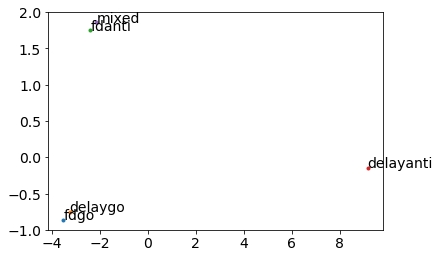

In [33]:
model = Model(m['trained on other tasks'])
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    
fdgo = params[1]
delaygo = params[3]
fdanti = params[4]
delayanti = params[6]

X = np.concatenate((fdgo,delaygo,fdanti,delayanti),axis = 0)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

task_list = ['fdgo','delaygo','fdanti','delayanti']
for x in range(len(X)):
    task = task_list[x]
    plt.plot(X_pca[x,0],X_pca[x,1],'.')
    plt.text(X_pca[x,0],X_pca[x,1],task)
    
mixed = X_pca[2,:] - X_pca[0,:] + X_pca[1,:]

plt.plot(mixed[0],mixed[1],'.')
plt.text(mixed[0],mixed[1],'mixed')

In [30]:
k

'untrained'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


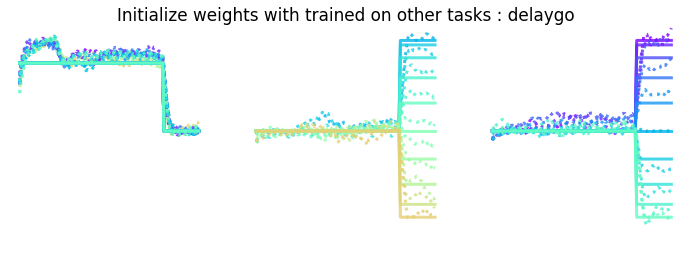

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_untrained/14_to_1_tasks/256_n_rnn/l2_w4_h0_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_untrained/14_to_1_tasks/256_n_rnn/l2_w4_h0_delayanti/0/model.ckpt


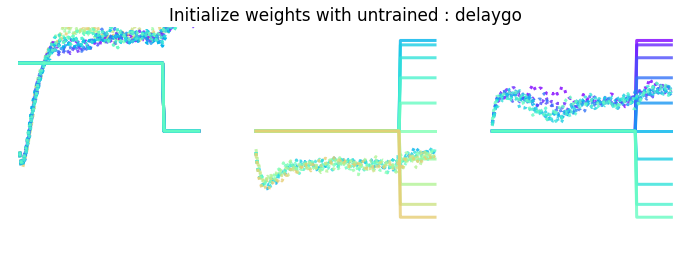

In [41]:
for k in m.keys():

    model = Model(m[k])
    hp = model.hp
    with tf.Session() as sess:
        model.restore()
        rule = 'delaygo'
        trial = generate_trials(rule, hp, 'test', noise_on = False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict)


    fig = plt.figure(figsize=(12, 4))

    granularity = 4
    al = .8
    lw = 3

    cmap=plt.get_cmap('rainbow')
    for x in range(20,60,granularity):
        for sp in range(2):
            ax = plt.subplot(1,3,sp+1)
            plt.plot(y_hat_tf[:,x,sp],':',c = cmap(x/80),linewidth = lw,alpha = al)
            plt.plot(trial.y[:,x,sp],'-',c = cmap(x/80),linewidth = lw,alpha = al)
            plt.ylim((-1.2,1.2))

            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
    plt.title('Initialize weights with '+ k + ' : '+rule)
    
    for x in range(0,40,granularity):
        for sp in [0,2]:
            ax = plt.subplot(1,3,sp+1)
            plt.plot(y_hat_tf[:,x,sp],':',c = cmap(x/80),linewidth = lw,alpha = al)
            plt.plot(trial.y[:,x,sp],'-',c = cmap(x/80),linewidth = lw,alpha = al)
            plt.ylim((-1.2,1.2))

            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

    
    plt.show()

In [ ]:
log[perf]

In [62]:
def plot_training(m):

    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        hp = model.hp
    task_list = hp['rule_trains']

    fig = plt.figure(figsize=(5, 5))
    cmap=plt.get_cmap('Greys')
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
        c = cmap((r+1)/(len(task_list)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',c = c,alpha = .5)
        ax.set_xlabel('Training Step (x 1000)')
        ax.set_ylabel('Log Cost [for each task]')
    #     plt.ylim([-6,2])

    plt.title(m)
    plt.show()    

In [63]:
all_rules = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              # 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

In [30]:
variance.compute_variance(m,rules = all_rules)

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
Variance saved at /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/variance_rule.pkl
Variance saved at /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/cr

ValueError: No hp found for model_dir /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/ckpts

Choosing 27 clusters


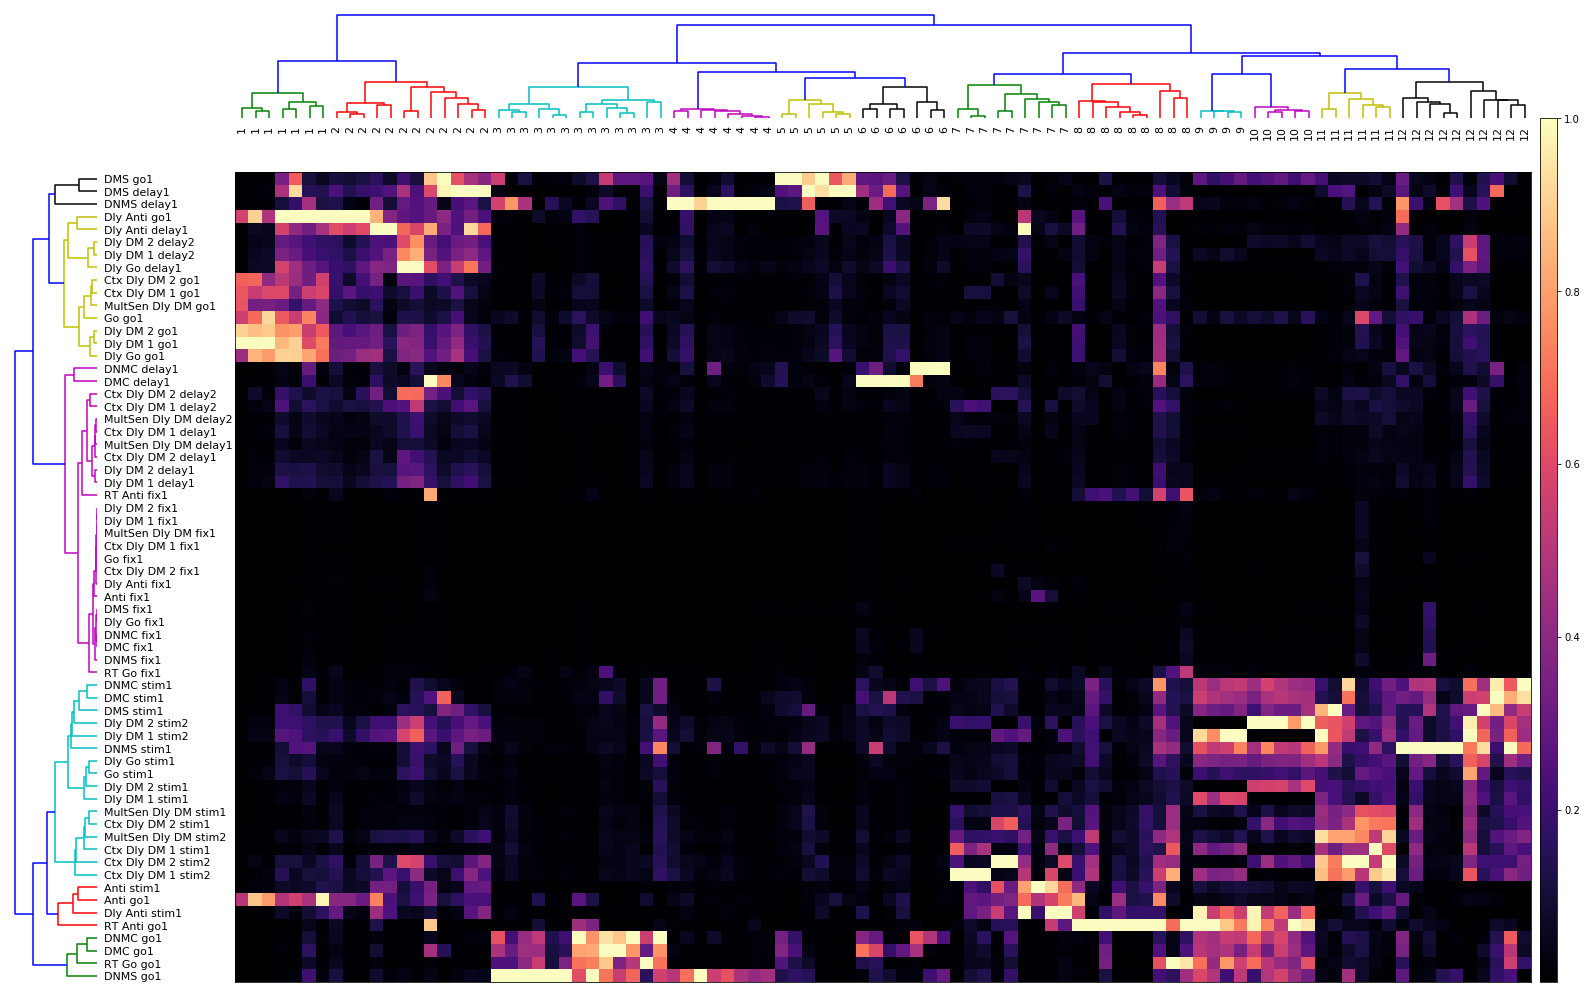

In [31]:
make_dendro(m)

In [196]:
data_folder = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus'
file_spec = 'transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/'
D_file = 'lesion_fps_hierarchical_ward_max_d3/cluster_var.npz'
d = os.path.join(data_folder,file_spec,D_file)
cluster_var = np.load(d)

In [199]:
cels = cluster_var['lesion_units_list'][1]
for x in range(2,n_cluster):
    cels = np.concatenate((cels,cluster_var['lesion_units_list'][x]),axis = 0)

In [200]:
m = os.path.join(data_folder,file_spec)
w_in, b_in, w_out, b_out = get_model_params(m)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


In [201]:
W_in = w_in[1][0,cels][np.newaxis,:]
task_list = [1,3,4,6]#fdgo,delaygo,fdanti,delayanti

for x in task_list:
    vec = w_in[x][0,cels]
    norm_vec = vec/np.max(vec)
    if x == task_list[0]: 
        W_in = norm_vec[np.newaxis,:]
    else:
        W_in = np.concatenate((W_in, norm_vec[np.newaxis,:]),axis = 0)

In [202]:
fig = plt.figure(figsize=(10,2),tight_layout=True,facecolor='white')
plt.imshow(W_in)
plt.show()

In [209]:
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
plt.imshow(cluster_var['D'])
plt.show()

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


In [223]:
import pylab

fig = pylab.figure(figsize=(10, 8))

cel_num = [CA.ind_active[x] for x in cluster_var['index_top']]

axmatrix = fig.add_axes([0.1,0.1,0.8,0.75])
D_im = axmatrix.matshow(cluster_var['D'], aspect='auto', origin='lower',cmap='magma')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

axdendro_top = fig.add_axes([0.1,.86,0.8,0.07])
W_im = axdendro_top.matshow(W_in, aspect='auto', origin='lower',cmap='magma')
axdendro_top.set_xticks([])
axdendro_top.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.92,0.1,0.01,0.8])
pylab.colorbar(D_im, cax=axcolor)

In [29]:
from collections import OrderedDict
def make_h_all(m,mode = 'test',rules = []):
    model = FixedPoint_Model(m, sigma_rec=0)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0

        h_all_byrule = OrderedDict()
        h_all_byepoch = OrderedDict()

        hp = model.hp
        n_hidden = hp['n_rnn']
        
        if len(rules)==0:
            rules = hp['rules']

        for rule in rules:
            trial = generate_trials(rule, hp, mode = mode, noise_on=False, batch_size = 100)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h = sess.run(model.h, feed_dict=feed_dict)

            for e_name, e_time in trial.epochs.items():
                # if 'fix' not in e_name:  # Ignore fixation period
                h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1],:,:]
                
            h_all_byrule[rule] = h
                
    return h_all_byepoch, h_all_byrule

In [30]:
from sklearn.decomposition import PCA
_, h_all_byrule = make_h_all(m,mode = 'test',rules = ['fdgo','delaygo', 'fdanti', 'delayanti'])

n_components = 256
rules = ['fdgo','delaygo','fdanti', 'delayanti']
rule = rules[0]
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))
for rule in rules[1:]:
    X_rule = h_all_byrule[rule]
    X_use = np.concatenate((X_use,np.reshape(X_rule[:],(-1,hp['n_rnn']))),axis = 0)

pca = PCA(n_components = n_components)
h_all_pca = pca.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


(0, 1)

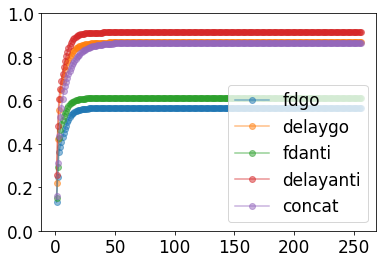

In [31]:
for rule in rules:
    X_rule = h_all_byrule[rule]
    X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))

    pca_rule = PCA(n_components = n_components)
    h_all_pca = pca_rule.fit_transform(X_use)

    plt.plot(range(1,n_components+1),np.cumsum(pca_rule.explained_variance_),'-o',alpha = .5,label = rule)

plt.plot(range(1,n_components+1),np.cumsum(pca.explained_variance_),'-o',alpha = .5,label = 'concat')      
plt.legend()
plt.ylim((0,1))

In [32]:
def get_model_params(model_dir,ckpt_n_dir = []):

    model = Model(model_dir)
    with tf.Session() as sess:
        if len(ckpt_n_dir)==0:
            model.restore()
        else:
            model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        
        w_in = params[:21]
        b_in = params[22]
        w_out = params[23]
        b_out = params[24]

    return w_in, b_in, w_out, b_out

In [34]:
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params
dims = 'tdr'
tasks = ['fdgo', 'delaygo', 'fdanti', 'delayanti']
h, trial, _ = make_h_trial_rule(m_set['trained on other tasks'],task_set = tasks)
epoch = 'stim1'

ind = -1
stim_angle = []
target_angle = []
r = []

for ri in range(len(tasks)):
    rule = tasks[ri]
    T_inds = get_T_inds(trial[rule],epoch)
    T_use = T_inds[ind]
    inds_use = np.min(trial[rule].stim_strength,axis=1)>.5
    r_temp = h[rule][T_use,inds_use,:].T
    stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1)
    stim_angle_temp = stim1_locs[inds_use]
    target_angle_temp = trial[rule].y_loc[-1,inds_use]
    
    if len(stim_angle)==0:
        stim_angle = stim_angle_temp
        target_angle = target_angle_temp
        r = r_temp
    else: 
        stim_angle = np.concatenate((stim_angle,stim_angle_temp))
        target_angle = np.concatenate((target_angle,target_angle_temp))
        r = np.concatenate((r,r_temp),axis = 1)
        
y1 = np.expand_dims(np.sin(stim_angle),axis = 1)
y2 = np.expand_dims(np.cos(stim_angle),axis = 1)
stim_y = np.concatenate((y1,y2),axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(stim_y,r.T)
Beta = model.coef_
B_stim,_ = LA.qr(Beta)

y1 = np.expand_dims(np.sin(target_angle),axis = 1)
y2 = np.expand_dims(np.cos(target_angle),axis = 1)
target_y = np.concatenate((y1,y2),axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(target_y,r.T)
Beta = model.coef_
B_target,_ = LA.qr(Beta)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [35]:
def get_var(h_rule,inds):

    h = h_rule[inds[-1],:,:]
    hD = np.dot(h,D.T)
    var_trial = np.var(hD,axis = 0)

    h = np.mean(h_rule[inds,:,:],axis = 1)
    hD = np.dot(h,D.T)
    var_time = np.var(hD,axis = 0)

    return var_trial, var_time

In [36]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha)
        plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, linewidth = linewidth, alpha = alpha)

In [37]:
n_components = 3
rule = 'delaygo'
_, h_all_byrule = make_h_all(m_set['trained on other tasks'],mode = 'test',rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti'])
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))

pca_rule = PCA(n_components = n_components)
h_all_pca = pca_rule.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_fr

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


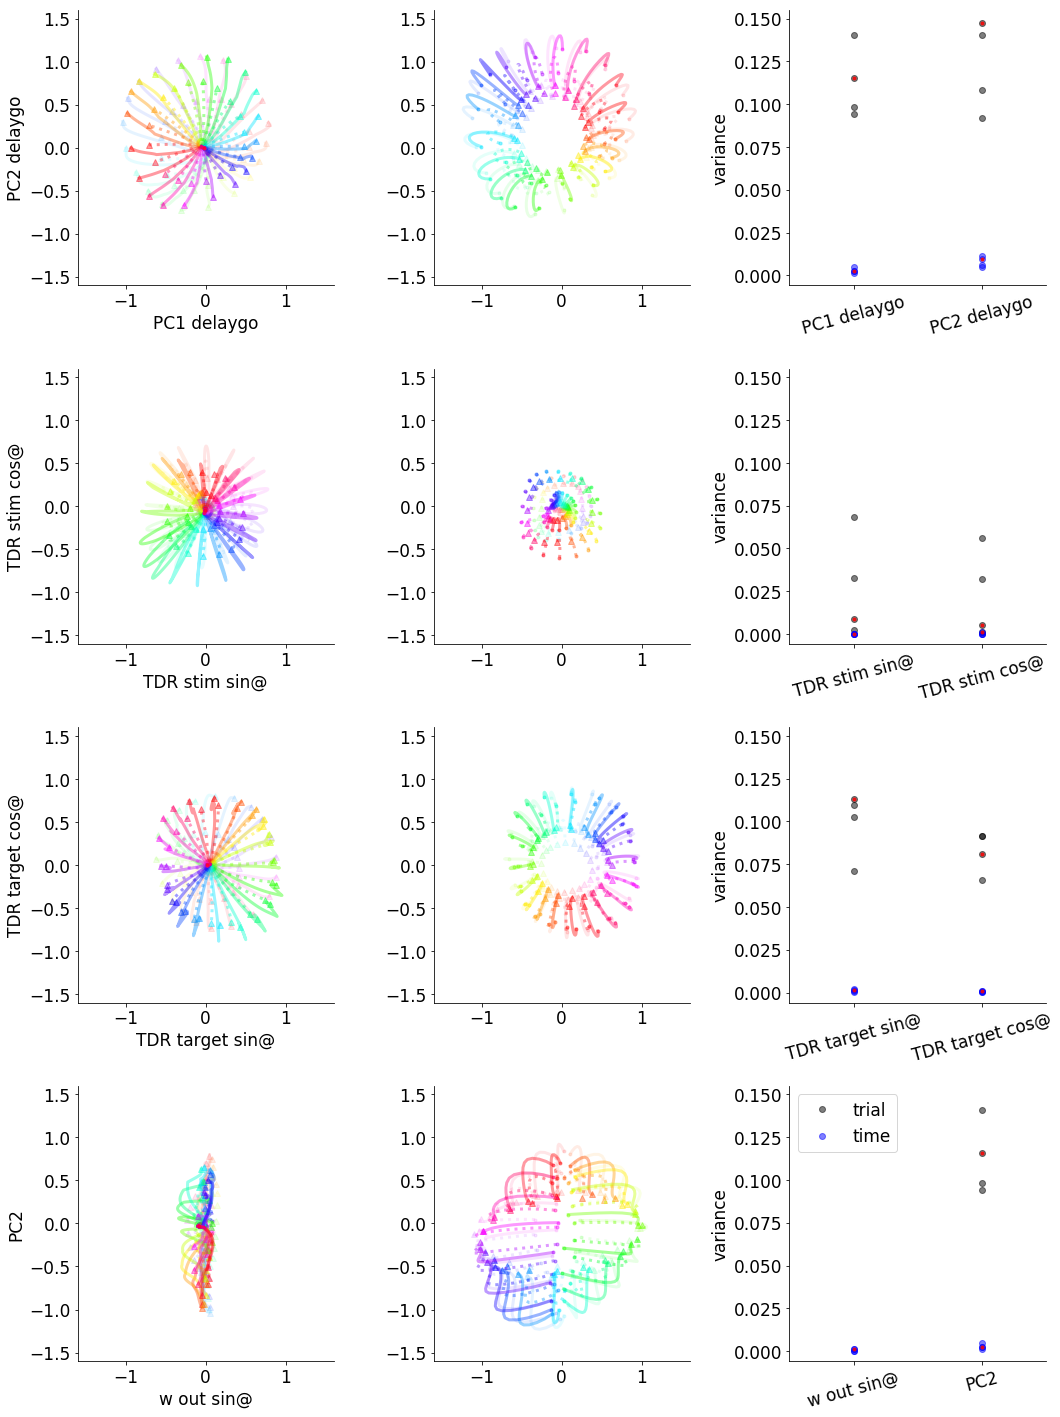

In [40]:
from tools_lnd import plot_N
rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti']
linestyles = [':','-',':','-']
color_list = [.1,.1,.4,.4]
trial_set = range(0,80,4)
n_steps = -25

_, _, w_out, _  = get_model_params(m_set['trained on other tasks'])

D_inds = {}
D_inds[1] = B_stim.T
D_inds[2] = B_target.T
D_inds[0] = np.concatenate((-pca_rule.components_[[0,],:],pca_rule.components_[[1,],:]),axis = 0)
D_inds[3] = np.concatenate((w_out[:,[1,]].T,-pca_rule.components_[[0,],:]),axis = 0)

axes_labels = {}
axes_labels[1] = ['TDR stim sin@','TDR stim cos@']
axes_labels[2] = ['TDR target sin@','TDR target cos@']
axes_labels[0] = ['PC1 '+rule,'PC2 '+rule]
axes_labels[3] = ['w out sin@','PC2']

nr = len(D_inds)
nc = 3
lim = 1.6
lim_neg = -lim

var = {}
var['trial'] = np.zeros((nr,2))
var['time'] = np.zeros((nr,2))

fig = plt.figure(figsize=(5*nc,5*nr),tight_layout=True,facecolor='white')
for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m_set['trained on other tasks'],rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))
    
    inds = {}
    inds['all'] = range(0,np.shape(X)[1])
    inds['stim'] = range(0,trial.epochs['go1'][0])
    inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
    
    for sp in range(nr):
        
        D = D_inds[sp]
        ax1 = plt.subplot(nr,nc,nc*sp+1)
        X_subselect = X[:,inds['stim'],:]
        clist = np.min(trial.stim_locs[trial_set,:],axis = 1)/(2*np.pi)
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
        plt.xlabel(axes_labels[sp][0])
        plt.ylabel(axes_labels[sp][1])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
#         var_trial, var_time = get_var(h_all_byrule[rule],inds['stim'])
#         var['trial'][sp,:] = var_trial
#         var['time'][sp,:] = var_time
        
#         ax3 = plt.subplot(nr,nc,nc*sp+2)
#         plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
#         plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
#         if sp==(nr-1):
#             plt.legend(['trial','time'])
#         if sp ==0:
#             stim_ylim = ax3.get_ylim()
#         else:
#             plt.ylim((stim_ylim))
                
#         plt.xlim((-.5,1.5))
#         plt.ylabel('variance')
#         plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
        
        
        ax2 = plt.subplot(nr,nc,nc*sp+2)
        X_subselect = X[:,inds['go'],:]
        clist = trial.y_loc[-1,trial_set]
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
        var_trial, var_time = get_var(h_all_byrule[rule],inds['all'])
        var['trial'][sp,:] = var_trial
        var['time'][sp,:] = var_time
        
        ax3 = plt.subplot(nr,nc,nc*sp+3)
        plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
        plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
        if rule == 'delayanti':
            plt.plot([0,1],var_trial,'.r',alpha = .8,label = 'trial')
            plt.plot([0,1],var_time,'.r',alpha = .8,label = 'time')
            
        
        if sp==(nr-1):
            plt.legend(['trial','time'])
        if sp ==0:
            go_ylim = ax3.get_ylim()
        else:
            plt.ylim((go_ylim))
                
        plt.xlim((-.5,1.5))
        plt.ylabel('variance')
        plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_fr

Text(0,0.5,'W out 1 (sin@)')

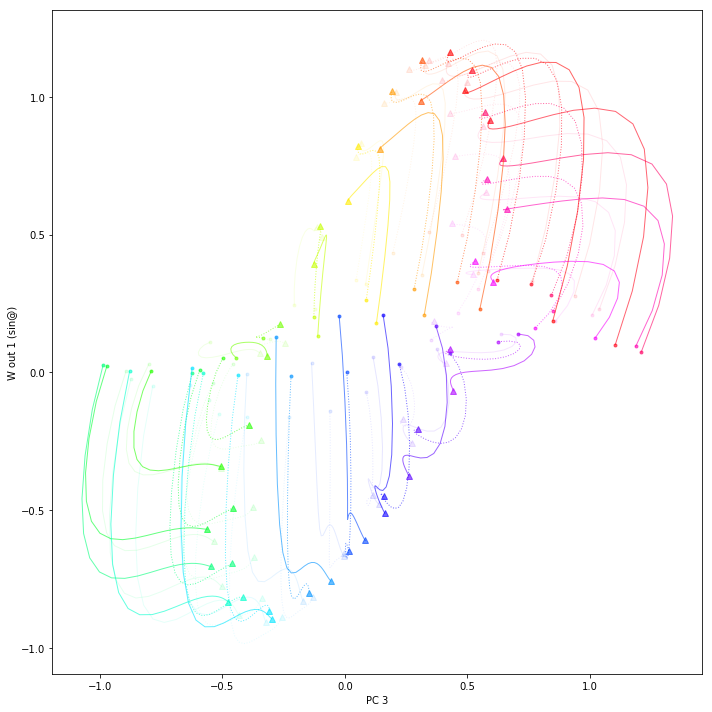

In [117]:
rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti']
linestyles = [':','-',':','-']
color_list = [.1,.1,.6,.6]
trial_set = range(0,80,4)
n_steps = -25

D = np.zeros((2,len(pca.components_[0,:])))
D[0,:] = pca.components_[0,:]
w_in, b_in, w_out, b_out  = get_model_params(m)
D[1,:] = w_out[:,2].T
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][n_steps:,trial_set,:],(1, 0, 2))
    clist = trial.y_loc[-1,trial_set]
    plot_N(X, D, clist,linestyle = linestyles[ri],alpha = color_list[ri])
    
plt.xlabel('PC 3')
plt.ylabel('W out 1 (sin@)')

In [41]:
def plot_N_jitter_3D(m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,qvals,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 2)
            
    return ax, x_t, params, alpha
            
def plot_FP_jitter_3D(ax,h0_set,x_t,D_use,params,alpha,n_jits = 10,c = 'k'):

    n_fps = np.shape(h0_set)[0]
    for n_fp in range(n_fps):
        h0 = h0_set[n_fp,:]
        for jit in range(n_jits):
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 1)

In [42]:
def get_model_params(model_dir,ckpt_n_dir = []):

    model = Model(model_dir)
    with tf.Session() as sess:
        if len(ckpt_n_dir)==0:
            model.restore()
        else:
            model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        
        w_in = params[:22]
        b_in = params[22]
        w_out = params[23]
        b_out = params[24]

    return w_in, b_in, w_out, b_out

In [43]:
rule = 'delaygo'
m = m_set['trained on other tasks']

w_in, b_in, w_out, b_out  = get_model_params(m)

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']

    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    
    w_in = params[:22]
    w_in_all = np.concatenate((w_in[:]),axis = 0)
    
    gate_inputs = np.dot(w_in_all.T,xh)+params[22]
    
    output = _activation(gate_inputs)

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_fr

In [44]:
def get_stepX_filename(task_list, t, step):
    filename = task_list[0]+'_'+task_list[1]+'_trial_'+str(t)+'_step_'+str(step)

    return filename

def get_filename(trial, epoch, t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[0,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

NameError: name 'fp_struct' is not defined

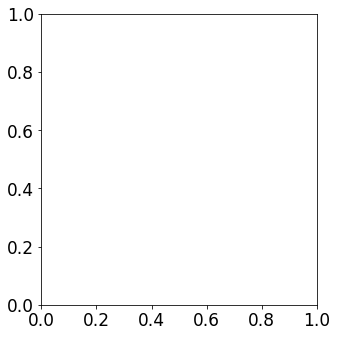

In [46]:
fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
ax1 = fig.add_subplot(111)

J_xstar = fp_struct['J_xstar']

for fp_num in range(np.shape(J_xstar)[0]):
    evals, _ = LA.eig(J_xstar[fp_num,:,:]) 
    ax1.plot(evals.real,evals.imag,'.k',alpha = .3,markerfacecolor = 'k')

In [52]:
n_components = 3
rule = 'delayanti'
_, h_all_byrule = make_h_all(m_set['trained on other tasks'],mode = 'test',rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti'])
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))

pca_rule = PCA(n_components = n_components)
h_all_pca = pca_rule.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt


In [63]:
from tools_lnd import gen_X_from_model_dir,get_T_inds,plot_N3D, comp_eig_decomp
from itertools import compress 
rule_set = ['delaygo','delayanti']
epoch = 'go1'
D_use = np.concatenate((w_out[:,[2,]].T,-pca_rule.components_[[0,],:],pca_rule.components_[[1,],:]),axis = 0).T
# D_use = pca_rule.components_[:3,:].T
trial_num = [0,40]
linestyle = ['-',':']
step_file = 'fp_stepX_tasks_transfer'
cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['mediumblue','gold']
n_interp = 20
axes_label1 = 'W out sin@'
axes_label2 = 'PC1'
axes_label3 = 'PC2'

In [64]:
from mpl_toolkits import mplot3d
from tools_lnd import plot_N3D

########## X TASK ###########
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(2):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    t = trial_num[ri]

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
    plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
    
    filename, _ = get_filename(trial, epoch, 0) #change 0 to t
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)

    ax, x_t, params, alpha = plot_N_jitter_3D(m,D_use,rule,t,epoch,sorted_fps,
                                              range(len(sorted_fps)),qvals,rand_step_coef = 0.1, 
                                              al = 1, linestyle = linestyle, n_steps = 200,
                                              n_jit = 0,c = cmap_discrete[ri])
    
#     plot_FP_jitter_3D(ax,sorted_fps,x_t,D_use,params,alpha,n_jits = 10,c = 'k')
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
               'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)

t = trial_num[0]
for step_i in range(20):
#     f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_'+str(t_set[1])+'_step_'+str(step_i)#'_'+str(t_set[1])
    f = get_stepX_filename(rule_set, 0, step_i) #change 0 to t
    filename = os.path.join(m,step_file,epoch,rule_set[0]+'_'+rule_set[1],f+'.npz')
    fp_struct = np.load(filename)
    step_fps = fp_struct['xstar']

    fp_project = np.dot(step_fps,D_use)
    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))

ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.set_xlim((-3, 3))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))
# ax.view_init(10, 60)

# tit = 'X TASK ' + epoch_set[ei]+' '+rule_set[0]+' vs.'+rule_set[1]
# if not os.path.exists(os.path.join(figpath,step_file)):
#     os.makedirs(os.path.join(figpath,step_file))
# figname = 'all_'+tit+'_'+step_file+'_'+str(t_set[0])
# plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
# plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_fr

In [55]:
%matplotlib

Using matplotlib backend: MacOSX


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_from_best/14_to_1_tasks/256_n_rnn/l2_w4_h5_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/transfer_learn/start_fr

Text(0.5,0,'PC 2')

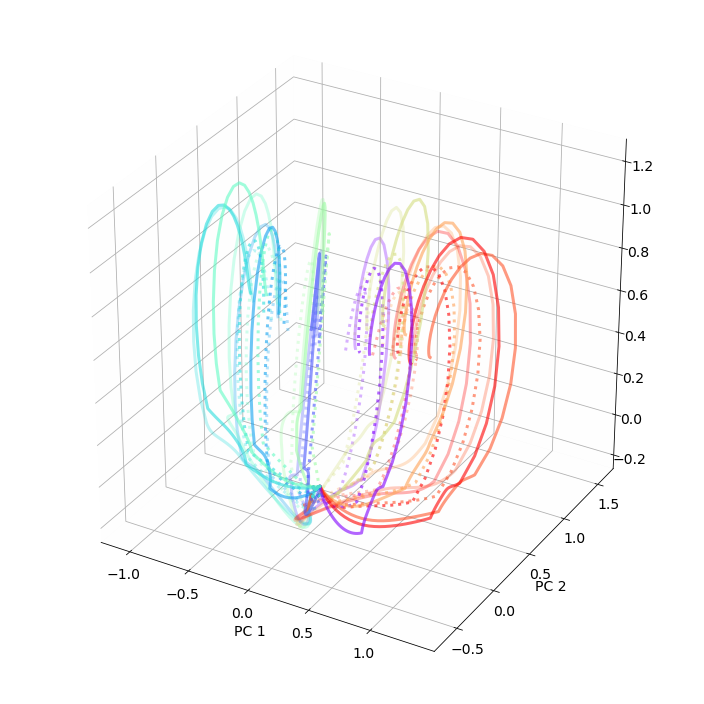

In [48]:
plt.rcParams.update({'font.size': 14})


rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti']
linestyles = [':','-',':','-']
color_list = [.3,.3,.6,.6]
trial_set = range(0,80,8)
n_steps = -25

D = pca.components_[:3,:]
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))
    clist = trial.y_loc[-1,trial_set]
    plot_N3D(ax, X, D, clist, linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [21]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[0,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [33]:
plt.rcParams.update({'font.size': 14})

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    alpha = .2
    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


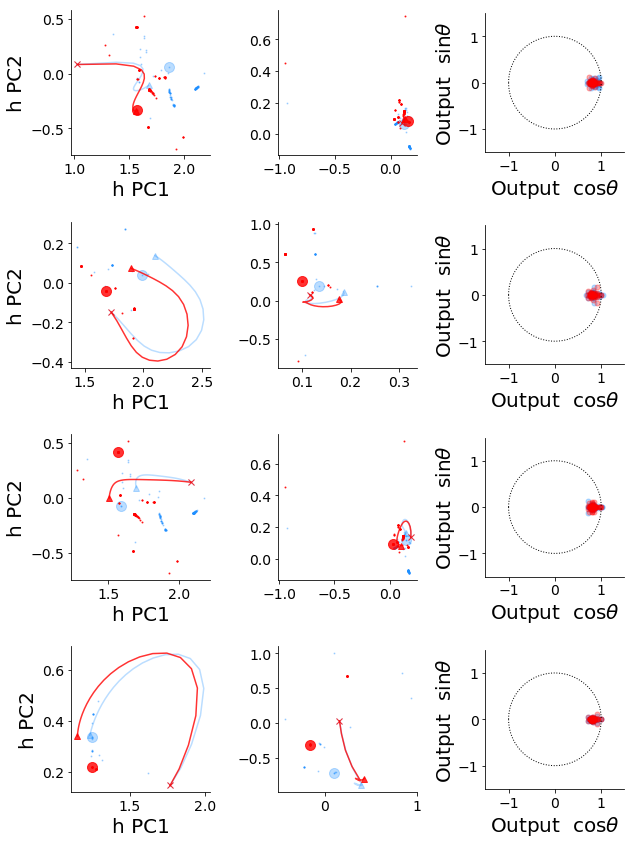

In [85]:
from tools_lnd import eigenspectrum_axes,out_axes,get_model_params
fp_file = 'tf_fixed_pts_mixed_context'

method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)

ti = 0
epoch_set = ['fix1','stim1','delay1','go1']
nr = len(epoch_set)
nc = 3
rule = 'delayanti'

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
out_theta = str(round(180*trial.y_loc[-1,ti]/np.pi,2))
_,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = [])

w_in, b_in, w_out, b_out = get_model_params(m)
D_out = w_out[:,1:]

save_dir = os.path.join(m,'mixed_context_fp')
fig = plt.figure(figsize=(3*nc,3*nr),tight_layout=True,facecolor='white')

for ri in range(len(epoch_set)):
    epoch = epoch_set[ri]
    T_inds = get_T_inds(trial,epoch)
    
    for subplot_i in range(2):

        if subplot_i>0:
            
            filename,_ = get_filename(trial, epoch, ti)
            f = os.path.join(m,fp_file,rule,filename+'.npz')
            tit_lesion = 'MIXED'
            a_plot = .8
            fp_color = 'r'
            
        else:
            #NO LESION
            if epoch=='fix1' or epoch=='delay1':
                f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_180.0.npz')
            else:
                f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_'+out_theta+'.npz')
            tit_lesion = 'FULL'
            a_plot = .3
            fp_color = 'dodgerblue'

        fp_struct = np.load(f)
        xstar = fp_struct['xstar']
        inputs = fp_struct['inputs'][[ti,],:]
        
        x_t = np.tile(fp_struct['inputs'][[ti,],:],(len(T_inds),1))
        h0 = h_all[:,ti,T_inds[0]]
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
            
        #identify relevant fp
        fp_num = proximate_fp(h_t[-1],fp_struct['xstar'])
        J_xstar = calc_jacobian_at(m,inputs,fp_struct['xstar'][[fp_num,],:],lesion_units = [])
        J_temp = np.dot(J_xstar,pca.components_.T)
        J_pca = np.dot(pca.components_,J_temp)
        evals, _ = LA.eig(J_xstar) #J_xstar             
        
        ax1 = fig.add_subplot(nr,nc,1+ri*nc)
        D_h = np.dot(D_use.T,h_t.T)
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_use.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_use.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax2 = fig.add_subplot(nr,nc,2+ri*nc)
        D_h = np.dot(D_out.T,h_t.T)
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_out.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_out.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax3 = fig.add_subplot(nr,nc,3+ri*nc)
        ax3.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
    
    
    eigenspectrum_axes(epoch,ax3)
    ax3.set_aspect('equal') 
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax3.plot(xs, ys,':k',linewidth = 1)
    ax3.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.5,1.1))
    plt.ylim((-.25,.25))
    
    PC_axes(ax1) 
    
    out_axes(ax2) 
#     ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))

#     #dist of proximal fp
#     dst_fp = LA.norm(xstar_full - xstar_lesion)
#     fp_diff_vec = xstar_full - xstar_lesion
#     fp_diff_pca = np.dot(fp_diff_vec,pca.components_.T) 
#     fp_diff_norm = LA.norm(fp_diff_pca)
#     ax2.set_title(rule+' corr : '+str(round(pearson[1,0],4))+' dst : '+str(round(fp_diff_norm,2)))
# #     ax2.set_title(str(pearson[1,0]))
        
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


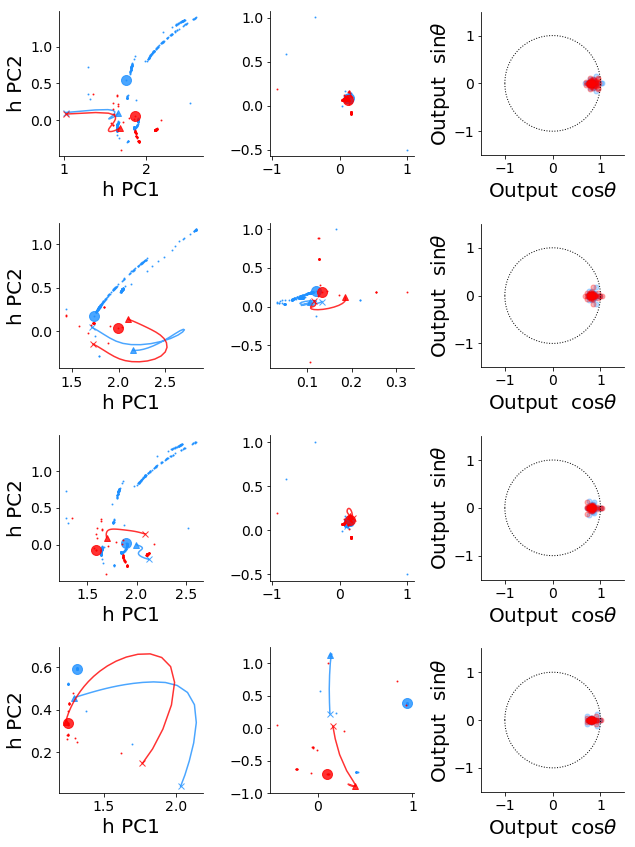

In [84]:
from tools_lnd import eigenspectrum_axes
fp_file = 'tf_fixed_pts_mixed_context'

method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)

ti = 0
epoch_set = ['fix1','stim1','delay1','go1']
nr = len(epoch_set)
nc = 3

save_dir = os.path.join(m,'mixed_context_fp')
fig = plt.figure(figsize=(3*nc,3*nr),tight_layout=True,facecolor='white')

rule = 'delayanti'
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
_,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = [])
D_fp = {}
n_components = 3
pca = PCA(n_components = n_components)
X_flat = np.reshape(h_all[:,:,T_inds],(-1,hp['n_rnn']))
fp_pca = pca.fit_transform(X_flat)
D_use = pca.components_.T
axes_labels = ['PCA_'+str(x+1) for x in range(n_components)]

for ri in range(len(epoch_set)):
    epoch = epoch_set[ri]
    
    
    for subplot_i in range(2):

        if subplot_i>0:
            
            rule = 'delayanti'
            trial = gen_trials_from_model_dir(m,rule,noise_on = False)
            T_inds = get_T_inds(trial,epoch)
            out_theta = str(round(180*trial.y_loc[-1,ti]/np.pi,2))
            _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = [])
            f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_'+out_theta+'.npz')
            tit_lesion = 'MIXED'
            a_plot = .8
            fp_color = 'r'
            
        else:
            #NO LESION
            rule = 'delaygo'
            trial = gen_trials_from_model_dir(m,rule,noise_on = False)
            T_inds = get_T_inds(trial,epoch)
            out_theta = str(round(180*trial.y_loc[-1,ti]/np.pi,2))
            _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = [])
            f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_'+out_theta+'.npz')
            tit_lesion = 'MIXED'
            a_plot = .8
            fp_color = 'dodgerblue'
            
        fp_struct = np.load(f)
        xstar = fp_struct['xstar']
        inputs = fp_struct['inputs'][[ti,],:]
        
        x_t = np.tile(fp_struct['inputs'][[ti,],:],(len(T_inds),1))
        h0 = h_all[:,ti,T_inds[0]]
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
        
        #identify relevant fp
        fp_num = proximate_fp(h_t[-1],fp_struct['xstar'])
        J_xstar = calc_jacobian_at(m,inputs,fp_struct['xstar'][[fp_num,],:],lesion_units = [])
        J_temp = np.dot(J_xstar,pca.components_.T)
        J_pca = np.dot(pca.components_,J_temp)
        evals, _ = LA.eig(J_xstar) #J_xstar             
        
        ax1 = fig.add_subplot(nr,nc,1+ri*nc)
        D_h = np.dot(D_use.T,h_t.T)
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_use.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_use.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax2 = fig.add_subplot(nr,nc,2+ri*nc)
        D_h = np.dot(D_out.T,h_t.T)
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_out.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_out.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax3 = fig.add_subplot(nr,nc,3+ri*nc)
        ax3.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax3.plot(xs, ys,':k',linewidth = 1)
    ax3.plot(xs, -ys,':k',linewidth = 1)
    eigenspectrum_axes(epoch,ax3)
    plt.xlim((.5,1.1))
    plt.ylim((-.25,.25))
    ax3.set_aspect('equal')  
    PC_axes(ax1) 
    out_axes(ax2) 
#     ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))

    #dist of proximal fp
    dst_fp = LA.norm(xstar_full - xstar_lesion)
    fp_diff_vec = xstar_full - xstar_lesion
    fp_diff_pca = np.dot(fp_diff_vec,pca.components_.T) 
    fp_diff_norm = LA.norm(fp_diff_pca)
#     ax2.set_title(rule+' corr : '+str(round(pearson[1,0],4))+' dst : '+str(round(fp_diff_norm,2)))
# #     ax2.set_title(str(pearson[1,0]))
        
plt.show()

In [ ]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[0,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = trial.epochs.keys()[epoch]+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [90]:
def plot_in_subspace(D_use,h_t,xstar,fp_num,fp_color,a_plot = .5):
    D_h = np.dot(D_use.T,h_t.T)
    plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
    plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
    plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
    D_fp_all = np.dot(D_use.T,xstar.T)
    plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
    D_fp_proximal = np.dot(D_use.T,xstar[fp_num,:])
    plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)

In [101]:
from tools_lnd import make_h_trial_rule
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

def make_Beta(m,task_list,fp_epoch,ind=-1):
    h_all,trial_all,_ = make_h_trial_rule(m,noise_on = False)
    T_inds = get_T_inds(trial_all[task_list[0]],fp_epoch)
    B,N = np.shape(h_all[task_list[0]][T_inds[ind],:,:])
    R = np.zeros((len(task_list)*B*len(T_inds),N))
    Y = np.zeros((9,len(task_list)*B*len(T_inds)))

    for rule_i in range(len(task_list)):
        rule = task_list[rule_i]
        T_inds = get_T_inds(trial_all[rule],fp_epoch)[-2:-1]
        r = np.reshape(h_all[rule][T_inds,:,:],(len(T_inds)*B,N))
        
        isanti = 'anti' in task_list[rule_i]
        ismemory = 'delay' in task_list[rule_i]
        y_anti = isanti*np.ones((np.shape(r)[0],1))
        y_memory = ismemory*np.ones((np.shape(r)[0],1))
        y_stim1 = np.repeat(np.min(trial_all[rule].stim_locs[:,[0,2]],axis=1),len(T_inds))
        y_stim2 = np.repeat(np.min(trial_all[rule].stim_locs[:,[1,3]],axis=1),len(T_inds))
        y_out = np.repeat(trial_all[rule].y_loc[-1,:],len(T_inds))
        
        inds = range((B*len(T_inds))*rule_i,(B*len(T_inds))*(rule_i+1))
        
        R[inds,:] = r
        Y[0,inds] = np.expand_dims(isanti,axis = 0)
        Y[1,inds] = np.expand_dims(ismemory,axis = 0)
        Y[2,inds] = np.expand_dims(np.sin(y_stim1),axis = 0)
        Y[3,inds] = np.expand_dims(np.cos(y_stim1),axis = 0)
        Y[4,inds] = np.expand_dims(np.sin(y_stim2),axis = 0)
        Y[5,inds] = np.expand_dims(np.cos(y_stim2),axis = 0)
        Y[6,inds] = np.expand_dims(np.sin(y_out),axis = 0)
        Y[7,inds] = np.expand_dims(np.cos(y_out),axis = 0)
        Y[8,inds] = np.repeat(T_inds,B)
        
        Y_labels = ['ANTI v. Pro','MEMORY v. DELAY','STIM1 '+ r' $\cos{\theta}$','STIM1 '+ r' $\sin{\theta}$',
                    'STIM2 '+ r' $\cos{\theta}$','STIM2 '+ r' $\sin{\theta}$','OUT '+ r' $\cos{\theta}$',
                    'OUT '+ r' $\sin{\theta}$','TIME']
        
    lm = linear_model.LinearRegression()
    model = lm.fit(Y.T,R)
    Beta = model.coef_
    Beta_qr,_ = LA.qr(Beta)
    return Beta_qr,Y_labels

In [ ]:
h_tf,trial_all,_ = make_h_trial_rule(m,noise_on = False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


KeyError: 'delay1'

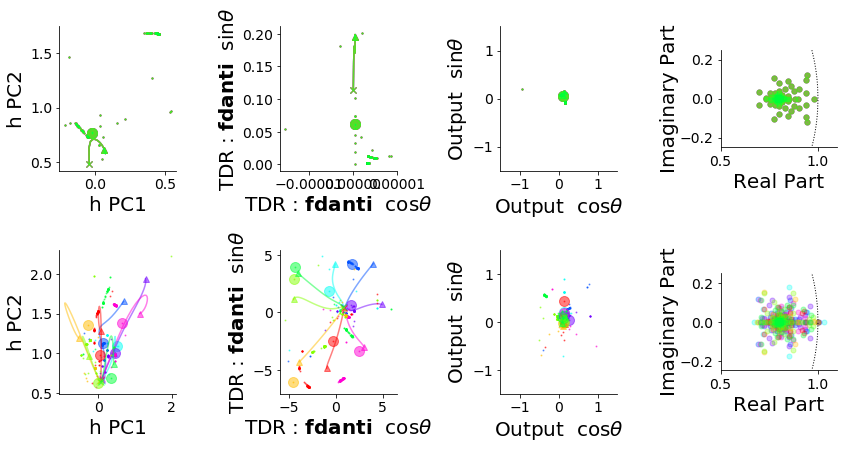

In [135]:
from tools_lnd import eigenspectrum_axes,TDR_axes,generate_Beta_epoch
fp_file = 'tf_fixed_pts_mixed_context'
n_steps_sim = 100

cmap = plt.get_cmap('hsv')
method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)

ti = 0
epoch_set = ['fix1','stim1','delay1','go1']
nr = len(epoch_set)
nc = 4

save_dir = os.path.join(m,'mixed_context_fp')
fig = plt.figure(figsize=(3*nc,3*nr),tight_layout=True,facecolor='white')

rule = 'delayanti'
rule_ax = 'fdanti'
epoch_ax = 'stim1'

trial_ax = gen_trials_from_model_dir(m,rule_ax,noise_on = False)
n_steps, n_trials, n_input_dim = np.shape(trial_ax.x)
_,h_ax = gen_X_from_model_dir(m,trial_ax,lesion_units_list = [])

pca = PCA(n_components = 2)
T_inds = get_T_inds(trial_ax,epoch_ax)
X_flat = np.reshape(h_ax[:,:,T_inds[-1]],(-1,hp['n_rnn']))
fp_pca = pca.fit_transform(X_flat)
D_pca = pca.components_.T

Beta_epoch = generate_Beta_epoch(h_tf[rule_ax],trial_all[rule_ax])
# D_tdr = Beta_epoch[epoch_ax]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
n_steps, n_trials, n_input_dim = np.shape(trial.x)
_,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = [])

for ri in range(len(epoch_set)):
    epoch = epoch_set[ri]
    T_inds = get_T_inds(trial,epoch)
    D_tdr = Beta_epoch[epoch]

    for ti in range(0,n_trials,int(n_trials/8)):
       
        filename, _ = get_filename(trial,epoch,ti)
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,filename+'.npz')
        fp_color = cmap(trial.y_loc[-1,ti]/(2*np.pi))
            
        if os.path.exists(f):
            fp_struct = np.load(f)
            xstar = fp_struct['xstar']
            inputs = fp_struct['inputs'][[0,],:]
        
        x_t = np.tile(fp_struct['inputs'][[0,],:],(n_steps_sim,1))
        h0 = h_all[:,ti,T_inds[0]]
#         h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
        h_t = h_all[:,ti,T_inds].T
        
        #identify relevant fp
        fp_num = proximate_fp(h_t[-1],fp_struct['xstar'])
        J_xstar = calc_jacobian_at(m,inputs,fp_struct['xstar'][[fp_num,],:],lesion_units = [])
        J_temp = np.dot(J_xstar,pca.components_.T)
        J_pca = np.dot(pca.components_,J_temp)
        evals, _ = LA.eig(J_xstar) #J_xstar             
        
        ax1 = fig.add_subplot(nr,nc,1+ri*nc)
        plot_in_subspace(D_pca,h_t,xstar,fp_num,fp_color,a_plot = .5)
        PC_axes(ax1)
        
        ax2 = fig.add_subplot(nr,nc,2+ri*nc)
        plot_in_subspace(D_tdr,h_t,xstar,fp_num,fp_color,a_plot = .5)
        TDR_axes(epoch,ax2,rule_ax)
        
        ax3 = fig.add_subplot(nr,nc,3+ri*nc)
        plot_in_subspace(D_out,h_t,xstar,fp_num,fp_color,a_plot = .5)
        out_axes(ax3) 
        
        ax4 = fig.add_subplot(nr,nc,4+ri*nc)
        ax4.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax4.plot(xs, ys,':k',linewidth = 1)
    ax4.plot(xs, -ys,':k',linewidth = 1)
    eigenspectrum_axes(epoch,ax4)
    ax4.set_aspect('equal') 
    ax4.set_xlim((.5,1.1))
    ax4.set_ylim((-.25,.25))
    
#     ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))
        
plt.show()

In [147]:
x_t = trial.x
x_t[:,:,5:] = np.tile(fp_struct['inputs'][[0,],5:],(n_steps,n_trials,1))

In [161]:
replace_rule = np.array(['delayanti', 'fdanti', 'delaygo', 'fdgo'])
rule_strength = [0,1,1,-1]
mixed_rule = 'delayanti'

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial_mixed = generate_trials(mixed_rule, hparams, mode='test', noise_on=False, batch_size=40,
                         replace_rule=replace_rule, rule_strength=rule_strength)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial_mixed, hparams)
    # run model
    h_mixed, y_hat_mixed = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.0


ERROR:root:Trying to access flag --op_conversion_fallback_to_while_loop before flags were parsed.


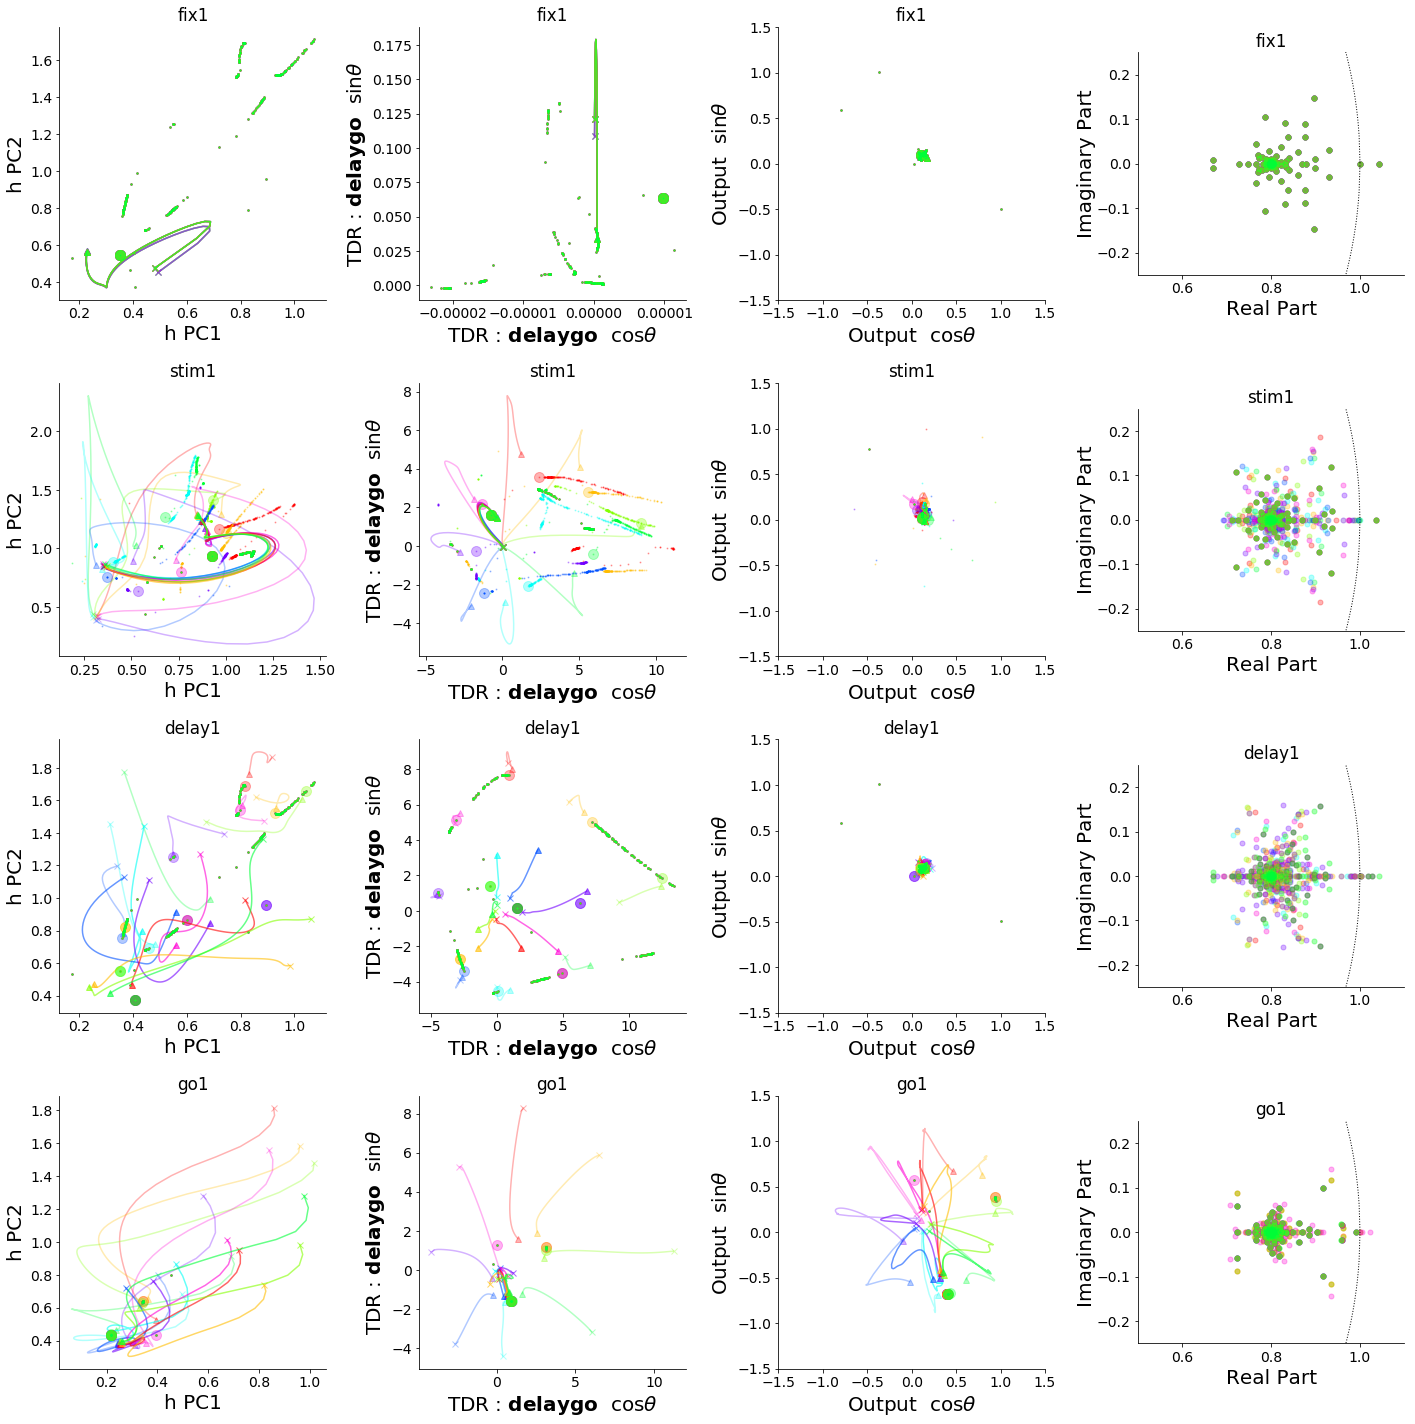

In [162]:
from tools_lnd import eigenspectrum_axes,TDR_axes,generate_Beta_epoch
fp_file = 'tf_fixed_pts_mixed_context'
n_steps_sim = 100

cmap = plt.get_cmap('hsv')
method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)

ti = 0
epoch_set = ['fix1','stim1','delay1','go1']
nr = len(epoch_set)
nc = 4

save_dir = os.path.join(m,'mixed_context_fp')
fig = plt.figure(figsize=(5*nc,5*nr),tight_layout=True,facecolor='white')

rule = 'delaygo'
rule_ax = 'delaygo'
mixed_rule = 'delayanti'
epoch_ax = 'stim1'

trial_ax = gen_trials_from_model_dir(m,rule_ax,noise_on = False)
n_steps, n_trials, n_input_dim = np.shape(trial_ax.x)
_,h_ax = gen_X_from_model_dir(m,trial_ax,lesion_units_list = [])

pca = PCA(n_components = 2)
T_inds = get_T_inds(trial_ax,epoch_ax)
X_flat = np.reshape(h_ax[:,:,T_inds[-1]],(-1,hp['n_rnn']))
fp_pca = pca.fit_transform(X_flat)
D_pca = pca.components_.T

Beta_epoch = generate_Beta_epoch(h_tf[rule_ax],trial_all[rule_ax])
# D_tdr = Beta_epoch[epoch_ax]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
n_steps, n_trials, n_input_dim = np.shape(trial.x)
_,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = [])

for ri in range(len(epoch_set)):
    epoch = epoch_set[ri]
    T_inds = get_T_inds(trial,epoch)
    D_tdr = Beta_epoch[epoch]
    
    for mixed in range(2):
        
        for ti in range(0,n_trials,int(n_trials/8)):

            filename, _ = get_filename(trial,epoch,ti)
            
        
            if mixed==0:
                f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,filename+'.npz')
                h0 = h_all[:,ti,T_inds[0]]
                fp_color = cmap(trial.y_loc[-1,ti]/(2*np.pi))
                a_plot = .3
            else:
                f = os.path.join(m,fp_file,mixed_rule,filename+'.npz')
                h0 = h_mixed[T_inds[0],ti,:]
                fp_color = cmap(trial_mixed.y_loc[-1,ti]/(2*np.pi))
                a_plot = .6

            if os.path.exists(f):
                fp_struct = np.load(f)
                xstar = fp_struct['xstar']
                inputs = fp_struct['inputs'][[0,],:]

            x_t = np.tile(fp_struct['inputs'][[0,],:],(n_steps_sim,1))
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

            #identify relevant fp
            fp_num = proximate_fp(h_t[-1],fp_struct['xstar'])
            J_xstar = calc_jacobian_at(m,inputs,fp_struct['xstar'][[fp_num,],:],lesion_units = [])
            evals, _ = LA.eig(J_xstar)        

            ax1 = fig.add_subplot(nr,nc,1+ri*nc)
            plot_in_subspace(D_pca,h_t,xstar,fp_num,fp_color,a_plot = a_plot)
            PC_axes(ax1)
            plt.title(epoch)

            ax2 = fig.add_subplot(nr,nc,2+ri*nc)
            plot_in_subspace(D_tdr,h_t,xstar,fp_num,fp_color,a_plot = a_plot)
            TDR_axes(epoch,ax2,rule_ax)
            plt.title(epoch)

            ax3 = fig.add_subplot(nr,nc,3+ri*nc)
            plot_in_subspace(D_out,h_t,xstar,fp_num,fp_color,a_plot = a_plot)
            out_axes(ax3) 
            plt.title(epoch)

            ax4 = fig.add_subplot(nr,nc,4+ri*nc)
            ax4.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
            plt.title(epoch)
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax4.plot(xs, ys,':k',linewidth = 1)
    ax4.plot(xs, -ys,':k',linewidth = 1)
    eigenspectrum_axes(epoch,ax4)
    ax4.set_aspect('equal') 
    ax4.set_xlim((.5,1.1))
    ax4.set_ylim((-.25,.25))
    
#     ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))
        
plt.show()

In [152]:
np.shape(x_t)

(100, 25)

In [154]:
np.shape(h_all)

(256, 80, 125)

In [155]:
np.shape(h_mixed)

(125, 80, 256)